In [4]:
import numpy as np
import healpy as hp
from tqdm.notebook import tqdm

In [5]:
class test_closure():
    def __init__(self, alt):
        self.alt = alt

    def query(self):
        alt = self.alt
        
        def closure(mult):
            vals = np.zeros(len(alt))
            for i in range(len(alt)):
                vals[i] = mult*alt[i]
            return vals

        return closure

v = test_closure(np.linspace(1,50,1000))
b = test_closure(np.linspace(1,20,1000))

c = njit(v.query())
d = njit(b.query())

def new(a1,a2):
    return c(a1) * d(a2)

class comb_test():
    def __init__(self, v, b):
        self.v = v
        self.b = b

    def query(self):        
        c = njit(v.query())
        d = njit(b.query())

        
        def closure(a1, a2):
            return np.sum(c(a1) * d(a2))

        return closure

NameError: name 'njit' is not defined

In [6]:
v = test_closure(np.linspace(1,50,1000))
b = test_closure(np.linspace(1,20,1000))

tt = comb_test(v,b)

NameError: name 'comb_test' is not defined

In [7]:
close = tt.query()

NameError: name 'tt' is not defined

In [8]:
comp = njit(close)

NameError: name 'njit' is not defined

In [9]:
%%timeit
comp(1,2)

NameError: name 'comp' is not defined

In [10]:
%%timeit
close(1,2)

NameError: name 'close' is not defined

# Backbone:

Layer is the base object for all objects in a simulation chain. Model describes the forward model associated with this layer, while the optional sampler can provide a way to sample for a PDF associated with the underlying parameters of the model to enable different realizations. Data can either be None (in which case the sampler needs to provide initial guesses for the forward model), an astropy quantity or uncertainty or a a DataQuery Object, which implements its own way to query data for a model.

In [11]:
from logic import Layer, SpatialModel, SpectralModel, Sampler, Observation

# The three baseclasses:

Emitters:

In [12]:
from emitter import CatalogEmitter, HealpixEmitter

Atmospheres:

In [13]:
from atmosphere import Atmosphere

Instruments:

In [14]:
# Initialize submodels:
instrument = instrument
atmosphere = atmosphere
emitters = [emitter1, emitter2]

# Get them all into one model
model = Model(instrument, atmosphere, emitters)

# Use this model to predict something
query = model.query(observation) # Query the model and returns a closure that is based on nonfixed parameters
query.predict(parameters)

NameError: name 'instrument' is not defined

# The specific implementations:

Emitter Model:

In [15]:
from dust_extinction.parameter_averages import G23
from nsb2.core.spectral import Bandpass
import astropy.constants as c
import jax.numpy as jnp

def blackbody(lam, T):
    f1 = 2*c.h.value*c.c.value**2
    f2 = c.h.value*c.c.value/c.k_B.value
    lam_m = lam * 1e-9  # nm to m
    return f1/lam_m**5 * 1/(np.exp(f2/(T*lam_m))-1) * 1e-6

class BlackBodyEBVModel(SpectralModel):
    def __init__(self, extmod=G23(Rv=3.1)):
        self.extmod = extmod
    
    def set_wvl(self, wvl):
        # Precompute extinction curve for unit E(B-V)
        self._ext_curve = np.array(self.extmod.extinguish(wvl, Ebv=1.0))
        # Set wvl in nanometers
        self.wvl = np.array(wvl.to(u.nm))
    
    def predict(self, parameters):
        logflux, teff, logebv = parameters.T
        bb_spec = blackbody(self.wvl[None, :], teff[:, None])
        extinction = np.power(self._ext_curve[None, :], np.exp(logebv)[:, None])
        return np.exp(logflux)[:, None] * bb_spec * extinction

Atmosphere Model:

In [16]:
def henyey_greenstein(g, theta):
    gsq = g**2
    return 1/(4*np.pi) * (1-gsq) / (1+gsq-2*g*np.cos(theta))**1.5

def rayleigh(theta):
    return 1/(4*np.pi)*3/4*(1+np.cos(theta)**2)

class AngstromHGModel(SpatialModel):
    def __init__(self, height, g):
        self.height = height.to(u.km).value
        self.rho_s  = [rayleigh, lambda x : henyey_greenstein(g, x)]

    def set_wvl(self, wvl):
        self.wvl = np.array(wvl.to(u.micron))

    def set_geometry(self, theta, i_alt, e_alt):
        self.theta = theta
        self.i_alt = i_alt
        self.e_alt = e_alt

        return self

    def predict(self, parameters):
        aod, angstrom, ssa = parameters

        t_r = self.t_r()
        t_m = self.t_m(aod, angstrom)

        total_extinction = t_r + t_m
        total_scattering = np.vstack([t_r,t_m*ssa])

        return (self.extinction(total_extinction, self.i_alt),
                self.scattering(total_extinction, total_scattering, self.theta, self.i_alt, self.e_alt))

    def X(self, Z):
        with np.errstate(invalid='ignore'):
            return 1/(np.cos(Z) + 0.50572*(96.07995-np.rad2deg(Z))**(-1.6364))

    def t_r(self):
        return 0.00879*(self.wvl)**-4.09 * np.exp(-self.height/8)

    def t_m(self, aod, angstrom):
        return aod*(self.wvl/0.6)**(-angstrom) * np.exp(-self.height/1.54)

    def extinction(self, tau, alt):
        return np.exp(-tau[np.newaxis,:]*self.X(np.pi/2 - alt)[...,np.newaxis])

    def scattering(self, tau, tau_s, theta, eval_alt, alt):
        return self.indicatrix(tau_s/tau, theta) * self.gradation(tau[np.newaxis,np.newaxis,np.newaxis,:],
                                                                  np.pi/2-eval_alt[:,:,np.newaxis,np.newaxis],
                                                                  np.pi/2-alt[np.newaxis,np.newaxis,:,np.newaxis])

    def indicatrix(self, taus, theta):
        return np.einsum('...bc,...b->...c', taus, np.stack([r(theta) for r in self.rho_s], axis=-1))

    def gradation(self, tau, Z, z):
        sec_Z = self.X(Z)
        sec_z = self.X(z)
        with np.errstate(divide='ignore', invalid='ignore'): # Necessary to avoid errors arising from dividing by zero
            sec_diff = sec_Z/(sec_z - sec_Z)
            exp_diff = (np.exp(-tau*sec_Z)- np.exp(-tau*sec_z))
            return np.where(Z==z, sec_Z * tau*(np.exp(-sec_Z*tau)), sec_diff * exp_diff)

In [17]:
atmo.model.set_wvl(observation.wvl)

NameError: name 'atmo' is not defined

In [18]:
from numba import jit, prange
@jit(nopython=True, parallel=True)
def extinction(tau, alt):
    Z = np.pi/2 - alt
    X = 1/(np.cos(Z) + 0.50572*(96.07995-np.rad2deg(Z))**(-1.6364))
    return np.exp(-tau[np.newaxis,:]*X[:,np.newaxis])

@jit(nopython=True, parallel=True, fastmath=False)
def extinction_fastmath(tau, bandpass, alt):
    Z = np.pi/2 - alt
    X = 1/(np.cos(Z) + 0.50572*(96.07995-np.rad2deg(Z))**(-1.6364))
    result = np.empty((len(alt)))
    for i in prange(len(alt)):
        for j in range(len(tau)):
            result[i] += np.exp(-tau[j] * X[i]) * bandpass[j]
    return result


In [19]:
alts = np.random.uniform(0.1, np.pi/2, 20771)

In [20]:
%%timeit
aod = 0.8
angstrom = 1
bandpass = hess1.bandpass(observation.wvl)
t_r = atmo.model.t_r()
t_m = atmo.model.t_m(aod, angstrom)

exts = extinction_fastmath(t_r + t_m, bandpass, alts)

NameError: name 'hess1' is not defined

In [21]:
from nsb2.emitter import stars
smap = stars.from_gaia_dr3_map()

/usr/local/lib/python3.13/site-packages/nsb2/emitter/stars.py:34: RuntimeWarning: invalid value encountered in subtract
  rp_bp = mag_map[2] - mag_map[1]


Instrument Model:

## Example:

Create observation example:

In [ ]:
import astropy
import astropy.units as u
from astropy.coordinates import AltAz, SkyCoord, SkyOffsetFrame, ICRS, Angle

location = astropy.coordinates.EarthLocation.from_geodetic(16.5028, -23.27280, 1.8*u.km)
obstime  = astropy.time.Time('2021-06-04T23:14:16', format='isot', scale='utc')
base = AltAz(obstime=obstime, location=location,
             pressure=1000*u.hPa, relative_humidity=0.3, temperature=20*u.deg_C, obswl=400*u.nm)

observation = Observation(base, SkyCoord.from_name('sgr a*'), -0.25*u.deg, Angle(3*u.deg), nside=2**4, ndim=4)

Create Stellar Example

In [23]:
import numpy as np
from astropy.coordinates import SkyCoord, Angle
from astropy.nddata import NDDataRef, StdDevUncertainty
import astropy.units as u
N = 3000000

lon = np.random.uniform(0,360,N) * u.deg
lat = np.random.uniform(-90,90,N) * u.deg
pm_ra_cosdec = np.random.uniform(-100,100,N)*u.mas/u.yr 
pm_dec = np.random.uniform(-100,100,N)*u.mas/u.yr 
s_coords = SkyCoord(lon, lat, frame='icrs')

logF = np.random.uniform(-20,-5,N)
Teff = np.random.uniform(2000,30000,N)
logebv = np.random.uniform(-4,0,N)

model = BlackBodyEBVModel()
model.set_wvl(observation.wvl)

stars = CatalogEmitter(s_coords, model, np.vstack([logF,Teff,logebv]).T)

NameError: name 'observation' is not defined

Create Diffuse Example

In [24]:
from astropy.coordinates import Galactic
N = hp.nside2npix(2**6)

logF = np.random.uniform(-5.2,-5,N)
Teff = np.random.uniform(5000,6000,N)
logebv = np.random.uniform(-4,-3,N)

galactic = HealpixEmitter(Galactic(), BlackBodyEBVModel(), np.vstack([logF,Teff,logebv]).T)

Create atmosphere example:

In [25]:
atmo = Atmosphere(AngstromHGModel(1.8*u.km, 0.8))

Instrument:

In [26]:
from nsb2.instrument import HESS
hess1 = HESS.CT1()

# All together:

In [27]:
from utils import LogRegularGridInterpolator

In [28]:
%%time
coords, data, starmap, starmodel = stars.query(observation)
galmaps, galmodel = galactic.query(observation)
Xi, Yi, atmomodel = atmo.query(observation)
pix_c, inst_model = SkyCoord(hess1.pix_pos[:,0], hess1.pix_pos[:,1], unit='rad', frame=observation.frame), hess1.spline_response

starmodel.set_wvl(observation.wvl)
galmodel.set_wvl(observation.wvl)
atmomodel.set_wvl(observation.wvl)
bandpass = hess1.bandpass(observation.wvl)

AttributeError: module 'nsb2.emitter.stars' has no attribute 'query'

Ideal world:

In [115]:
def simulate(parameters):
    eff, xshift, yshift, x_sigma, y_sigma, aod, angstrom, ssa = parameters
    
    # Create Instrument
    YpXp, splines = inst_model.predict([eff, xshift, yshift, x_sigma, y_sigma])
    
    # Create atmosphere objects
    YiXi, ext, scat = atmomodel.predict([aod, angstrom, ssa])
    sp_ext = LogRegularGridInterpolator(YiXi, ext)
    
    # Go over emitters
    direct_rates, skymaps = [], []
    for emitter in all_emitters:
        # Calculate rates for catalog emitters
        if type(emitter) == CatalogEmitter:
            latlon, data, model, skymap = emitter[0], emitter[1], emitter[2]
            bp_rate = np.sum(model.predict(data)*sp_ext(latlon)*bandpass, axis=1)
            
            rates = []
            for i, spline in enumerate(splines):
                mask = ((spline.bins[0][0] <= latlon[:,1]) & (latlon[:,1] <= spline.bins[0][-1]) & 
                        (spline.bins[1][0] <= latlon[:,0]) & (latlon[:,0] <= spline.bins[1][-1]))
                rates.append(np.sum(spline(latlon[mask])*bp_rate[mask]))
        
            direct_rates.append(rates)
            skymaps.append(skymap)
    
        # Calculate rates for diffuse emitters
        if type(emitter) == DiffuseEmitter:
            data, model = emitter[0], emitter[1]
            pix_data = hp.get_interp_val(data, np.rad2deg(YpXp[:,1]), np.rad2deg(YpXp[:,0]), nest=True, lonlat=True)
            rates = np.sum(model.predict(pix_data) * sp_ext(YpXp) * bandpass, axis=1)
            
            direct_rates.append(rates)
            skymaps.append(model.predict(data))
    
    # Combine results for direct rates
    direct_rates = np.sum(direct_rates, axis=0)
    
    # Calculate interpolator for indirect rates
    bp_atmo_map = scat.value * np.sum(skymaps, axis=0) * bandpass
    sp_scat = LogRegularGridInterpolator(YiXi, np.sum(bp_atmo_map, axis=(-2,-1)))
    indirect_rates = sp_scat(YpXp)

    return direct_rates + indirect_rates

In [111]:
simulate([0.8,0,0,1,1,0.2,1.2,0.9])

AttributeError: 'list' object has no attribute 'predict'

Create ground truth:

In [309]:
%%timeit
gb = galmodel.predict(galmaps)

288 ms ± 28.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [310]:
gb.shape

(49152, 100)

In [315]:
%%time
dat2 = hp.get_interp_val(gb.T, pix_a.spherical.lon.deg, pix_a.spherical.lat.deg, nest=True, lonlat=True)

CPU times: user 1.64 ms, sys: 956 μs, total: 2.59 ms
Wall time: 1.87 ms


In [311]:
%%timeit
dat2 = hp.get_interp_val(galmaps.T, pix_a.spherical.lon.deg, pix_a.spherical.lat.deg, nest=True, lonlat=True)
specs2 = galmodel.predict(dat2.T)

4.42 ms ± 46.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [302]:
%%time
ext, scat = atmomodel.predict([0.7,1.8,0.85])
sp_ext = LogRegularGridInterpolator([Xi,Yi], ext)

# Extinction for point sources:
X, Y = coords.lon.rad, coords.lat.rad
Xp, Yp = hess1.pix_pos[:,0], hess1.pix_pos[:,1]
specs1 = starmodel.predict(data)
specs1 = np.array(np.sum(specs1*sp_ext(np.vstack([Y,X]).T)*bandpass, axis=1))

weight = np.zeros(len(hess1.pix_pos))
for i, spline in enumerate(inst_model):
    mask = ((spline.bins[0][0] <= X) & (X <= spline.bins[0][-1]) & 
            (spline.bins[1][0] <= Y) & (Y <= spline.bins[1][-1]))
    weight[i] = np.sum(spline(X[mask], Y[mask])*specs1[mask])

# Extinction for diffuse values:
pix_a = pix_c.transform_to(observation.origin)
dat2 = hp.get_interp_val(galmaps.T, pix_a.spherical.lon.deg, pix_a.spherical.lat.deg, nest=True, lonlat=True)
specs2 = galmodel.predict(dat2.T)
specs2 = np.sum(specs2 * sp_ext(np.vstack([Yp,Xp]).T)*bandpass, axis=1)

# Scattering for point sources and diffuse
all_scat = scat.value * (1.3*galmodel.predict(galmaps) + starmap)*bandpass
sp_scat = LogRegularGridInterpolator([Xi,Yi], np.nansum(all_scat, axis=(-2,-1)))
specs3 = sp_scat(np.vstack([Yp,Xp]).T)

final_val = weight + specs2 + specs3
final_val = 0.8*(final_val + np.random.normal(scale = final_val*0.05))

CPU times: user 138 ms, sys: 266 ms, total: 404 ms
Wall time: 405 ms


Try to fit with mcmc:

In [227]:
def fit_f(eff, ag, xshift, yshift, aod, angstrom, ssa):
    xshift = np.deg2rad(xshift)
    yshift = np.deg2rad(yshift)

    X, Y = coords.lon.rad+xshift, coords.lat.rad+yshift
    Xp, Yp = hess1.pix_pos[:,0]-xshift, hess1.pix_pos[:,1]-yshift
    
    ext, scat = atmomodel.predict([aod,angstrom,ssa])
    sp_ext = LogRegularGridInterpolator([Xi,Yi], ext)
    
    # Extinction for point sources:
    specs1 = starmodel.predict(data)
    specs1 = np.array(np.sum(specs1*sp_ext(np.vstack([Y,X]).T)*bandpass, axis=1))
    specs1 = specs1 * np.random.normal(loc=1,scale=0.03, size=specs1.shape)
    
    weight = np.zeros(len(hess1.pix_pos))
    for i, spline in enumerate(inst_model):
        mask = ((spline.bins[0][0] <= X) & (X <= spline.bins[0][-1]) & 
                (spline.bins[1][0] <= Y) & (Y <= spline.bins[1][-1]))
        weight[i] = np.sum(spline(X[mask], Y[mask])*specs1[mask])
    
    # Extinction for diffuse values:
    pix_a = SkyCoord(Xp, Yp, unit='rad', frame=observation.frame).transform_to(observation.origin)
    dat2 = hp.get_interp_val(galmaps.T, pix_a.spherical.lon.deg, pix_a.spherical.lat.deg, nest=True, lonlat=True)
    specs2 = galmodel.predict(dat2.T)
    specs2 = np.sum(specs2 * sp_ext(np.vstack([Yp,Xp]).T)*bandpass, axis=1)
    
    # Scattering for point sources and diffuse
    all_scat = scat.value * (ag*galmodel.predict(galmaps) + starmap)*bandpass
    sp_scat = LogRegularGridInterpolator([Xi,Yi], np.nansum(all_scat, axis=(-2,-1)))
    specs3 = sp_scat(np.vstack([Yp,Xp]).T)
    
    return eff*(weight + specs2 + specs3)
    
def residual(p):
    v = p.valuesdict()
    return ((fit_f(v['eff'],v['ag'],v['xshift'],v['yshift'],v['aod'],v['angstrom'],v['ssa']) - final_val)/(0.1*final_val))

In [228]:
import lmfit
p = lmfit.Parameters()
p.add_many(
    ('eff', 0.9, True, 0, 1), 
    ('ag', 1, True, 0, 2), 
    ('xshift', 0.01, True, -0.1, 0.1), 
    ('yshift', 0.01, True, -0.1, 0.1), 
    ('aod', 0.1, True, 0.01, 3.0), 
    ('angstrom', 1.2, True, 0.1, 3.0), 
    ('ssa', 0.85, True, 0.6, 1.0)
)

nwalkers = 30
pos = [list(p.valuesdict().values()) + 1e-2*np.random.randn(len(p)) 
       for i in range(nwalkers)]

res = lmfit.minimize(residual, p, pos=pos, method='emcee', nan_policy='omit', burn=200, steps=5000,
                     thin=5, nwalkers=nwalkers, is_weighted=True, progress=True, workers=4)

/usr/local/lib/python3.13/multiprocessing/popen_fork.py:67: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████████████████████████████████| 5000/5000 [4:30:06<00:00,  3.24s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 100;
tau: [439.96120266 266.35988507 140.41896837 155.92025949 377.93489985
 371.26195997 372.6216755 ]


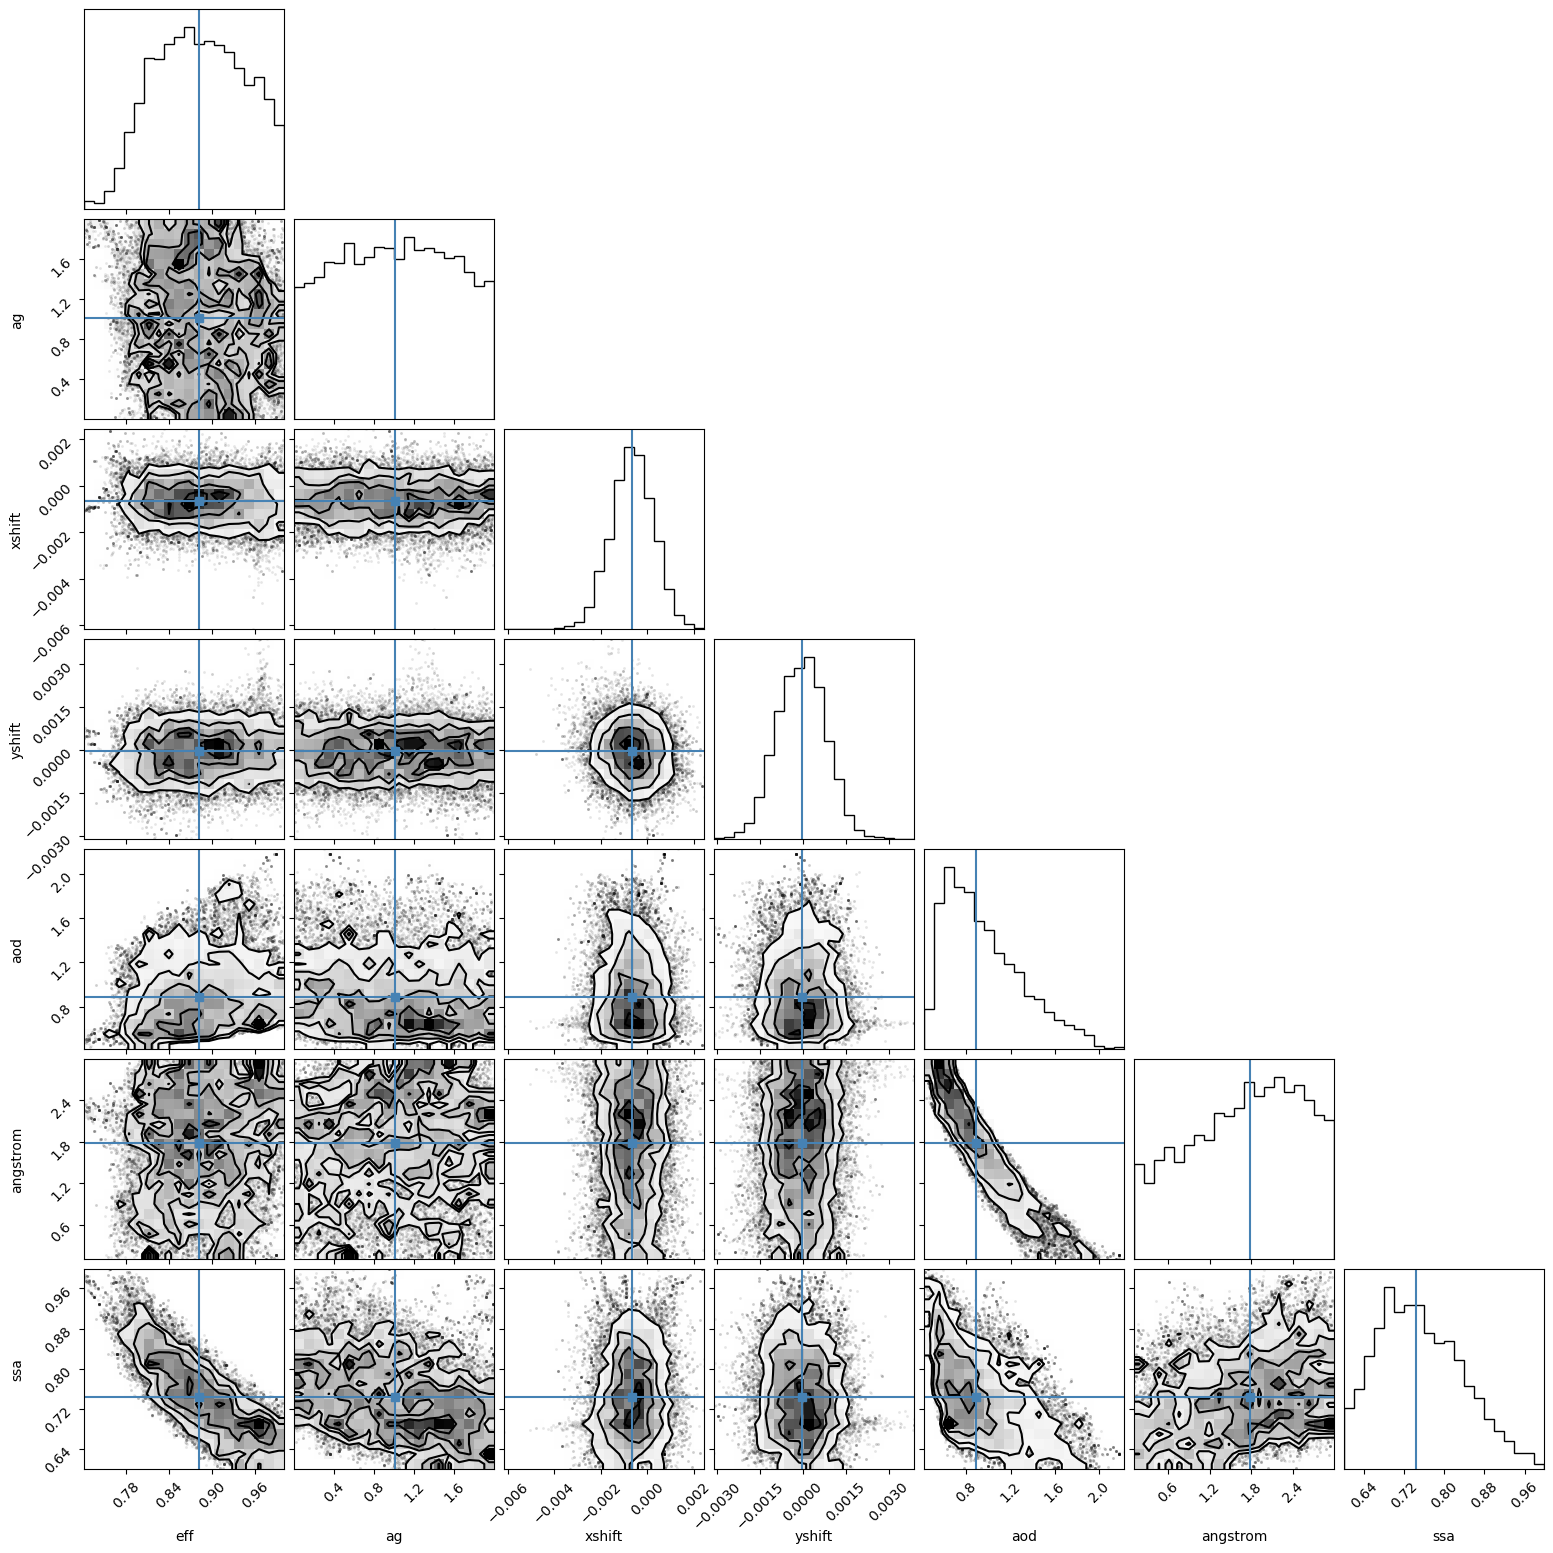

In [236]:
import corner

emcee_plot = corner.corner(res.flatchain, labels=res.var_names,
                           truths=list(res.params.valuesdict().values()))

In [237]:
lmfit.report_fit(res.params)

[[Variables]]
    eff:       0.88111845 +/- 0.06883830 (7.81%) (init = 0.9)
    ag:        1.01120914 +/- 0.65010606 (64.29%) (init = 1)
    xshift:   -6.4012e-04 +/- 9.0897e-04 (142.00%) (init = 0.01)
    yshift:   -4.8976e-05 +/- 8.5212e-04 (1739.88%) (init = 0.01)
    aod:       0.88833716 +/- 0.35655515 (40.14%) (init = 0.1)
    angstrom:  1.77913691 +/- 0.90650167 (50.95%) (init = 1.2)
    ssa:       0.74426146 +/- 0.08752308 (11.76%) (init = 0.85)
[[Correlations]] (unreported correlations are < 0.100)
    C(aod, angstrom)  = -0.9260
    C(eff, ssa)       = -0.8081
    C(aod, ssa)       = -0.5246
    C(ag, ssa)        = -0.3133
    C(angstrom, ssa)  = +0.2804
    C(eff, aod)       = +0.2350
    C(eff, ag)        = -0.1207
    C(xshift, yshift) = -0.1068
    C(ag, aod)        = -0.1020


In [ ]:
0.8,0.9,0,0,0.7,1.8,0.85

# Fast pixel assignment

In [239]:
N = 20000
X,Y = np.random.uniform(-3,3,N), np.random.uniform(-3,3,N)
latlon = np.deg2rad(np.vstack([Y, X]).T)

In [240]:
@jit(nopython=True, parallel=True)
def compute_weights_parallel(centers, values_stack, coords):
    n_items = values_stack.shape[0]
    weights = np.empty(n_items, dtype=np.float64)
    
    # Use prange instead of range for parallel execution
    for item_idx in prange(n_items):
        values = values_stack[item_idx]
        
        height, width = values.shape
        n_points = coords.shape[0]
        result = 0.0

        ystart, ystep = centers[item_idx][0][0], centers[item_idx][0][1] - centers[item_idx][0][0]
        xstart, xstep = centers[item_idx][1][0], centers[item_idx][1][1] - centers[item_idx][1][0]
        # Inner loop stays sequential
        for i in range(n_points):
            y, x = coords[i, 0], coords[i, 1]
            y = (y - ystart) / ystep
            x = (x - xstart) / xstep
            
            if y < 0 or y >= height-1 or x < 0 or x >= width-1:
                continue
                
            y0, x0 = int(y), int(x)
            y1, x1 = y0 + 1, x0 + 1
            fy, fx = y - y0, x - x0
            
            v00 = values[y0, x0]
            v01 = values[y1, x0]
            v10 = values[y0, x1]
            v11 = values[y1, x1]
            
            interpolated = (1-fx)*(1-fy)*v00 + fx*(1-fy)*v10 + (1-fx)*fy*v01 + fx*fy*v11
            result += interpolated
        
        weights[item_idx] = result
    
    return weights

In [241]:
%%timeit
weights_mp = compute_weights_parallel(centers, res[0], latlon)

15.7 ms ± 493 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [229]:
j = np.random.uniform(size=(49152, 400)).T
pix_x = np.random.uniform(0, 180, 960*1)
pix_y = np.random.uniform(0, 80, 960*1)

In [231]:
%%timeit
dat2 = hp.get_interp_val(j, pix_x, pix_y, nest=True, lonlat=True)

4.41 ms ± 145 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [234]:
10000*0.05

500.0